<a href="https://colab.research.google.com/github/Revati1201/Emotion-Recognition/blob/main/Emotion_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip -q '/content/drive/MyDrive/Classification-20240725T080950Z-001.zip' -d '/content/drive/MyDrive/unzipped_folder'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Training directory exists.
Validation directory exists. Contents:
['Confusion', 'Engagement', 'Boredom', 'Frustration']
Found 6600 images belonging to 4 classes.
Found 8041 images belonging to 4 classes.


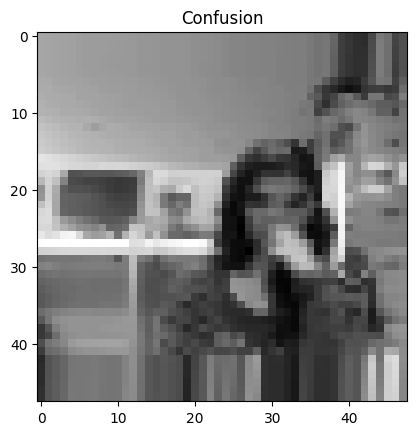

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 44, 44, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2  (None, 22, 22, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 22, 22, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 20, 20, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 10, 10, 128)       0         
 g2D)                                                   

ValueError: Unexpected value for `steps_per_epoch`. Received value is 0. Please check the docstring for `model.fit()` for supported values.

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from google.colab import drive
import os
from matplotlib import pyplot as plt
import numpy as np

IMG_HEIGHT = 48
IMG_WIDTH = 48
batch_size = 32

# Mount Google Drive
drive.mount('/content/drive')

train_data_dir = '/content/drive/MyDrive/unzipped_folder/Classification/Frame20/Train'
validation_data_dir = '/content/drive/MyDrive/unzipped_folder/Classification/Frame20/Test'

# Verify directory paths
if not os.path.exists(train_data_dir):
    print(f"Training directory {train_data_dir} does not exist.")
else:
    print("Training directory exists.")

if not os.path.exists(validation_data_dir):
    print(f"Validation directory {validation_data_dir} does not exist.")
else:
    print("Validation directory exists. Contents:")
    print(os.listdir(validation_data_dir))

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    color_mode='grayscale',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    color_mode='grayscale',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

# Verify our generator by plotting a few faces and printing corresponding labels
class_labels = ['Engagement', 'Frustration', 'Boredom', 'Confusion']

img, label = train_generator.__next__()

import random

i = random.randint(0, (img.shape[0])-1)
image = img[i]
labl = class_labels[label[i].argmax()]
plt.imshow(image[:, :, 0], cmap='gray')
plt.title(labl)
plt.show()

# Create the model
model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(48, 48, 1)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))

model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(4, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print(model.summary())

train_path = "/content/drive/MyDrive/Classification/Frame20/Train"
test_path = "/content/drive/MyDrive/Classification/Frame20/Test"

num_train_imgs = 0
for root, dirs, files in os.walk(train_path):
    num_train_imgs += len(files)

num_test_imgs = 0
for root, dirs, files in os.walk(test_path):
    num_test_imgs += len(files)

epochs = 5

history = model.fit(train_generator,
                    steps_per_epoch=num_train_imgs // batch_size,
                    epochs=epochs,
                    validation_data=validation_generator,
                    validation_steps=num_test_imgs // batch_size)

model.save('emotion_detection_model_100epochs.h5')

# Plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

print(f"Final Training Accuracy: {accuracy[-1]:.2f}")
print(f"Final Validation Accuracy: {val_accuracy[-1]:.2f}")

# Test the model
from keras.models import load_model

my_model = load_model('emotion_detection_model_100epochs.h5', compile=False)

# Generate a batch of images
test_img, test_lbl = validation_generator.__next__()
predictions = my_model.predict(test_img)

predictions = np.argmax(predictions, axis=1)
test_labels = np.argmax(test_lbl, axis=1)

from sklearn import metrics
print("Accuracy =", metrics.accuracy_score(test_labels, predictions))

# Confusion Matrix - verify accuracy of each class
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(test_labels, predictions)
sns.heatmap(cm, annot=True)

# Check results on a few select images
n = random.randint(0, test_img.shape[0] - 1)
image = test_img[n]
orig_labl = class_labels[test_labels[n]]
pred_labl = class_labels[predictions[n]]
plt.imshow(image[:, :, 0], cmap='gray')
plt.title("Original label is:" + orig_labl + " Predicted is: " + pred_labl)
plt.show()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Training directory exists.
Validation directory exists. Contents:
['Boredom', 'Confusion', 'Frustration', 'Engagement']
Found 6600 images belonging to 4 classes.
Found 13514 images belonging to 4 classes.


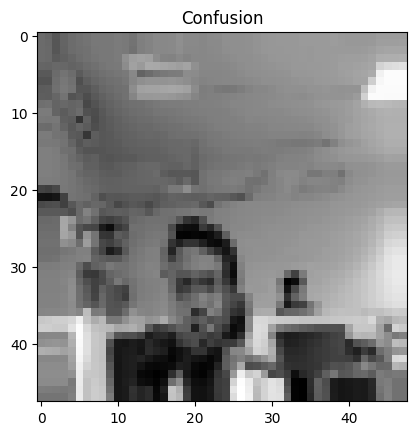

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 46, 46, 32)        320       
                                                                 
 conv2d_9 (Conv2D)           (None, 44, 44, 64)        18496     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 22, 22, 64)        0         
 g2D)                                                            
                                                                 
 dropout_8 (Dropout)         (None, 22, 22, 64)        0         
                                                                 
 conv2d_10 (Conv2D)          (None, 20, 20, 128)       73856     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 10, 10, 128)       0         
 g2D)                                                 

ValueError: Unexpected value for `steps_per_epoch`. Received value is 0. Please check the docstring for `model.fit()` for supported values.

In [ ]:


from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from google.colab import drive
import os
from matplotlib import pyplot as plt
import numpy as np

IMG_HEIGHT = 48
IMG_WIDTH = 48
batch_size = 32

# Mount Google Drive
drive.mount('/content/drive')

train_data_dir = '/content/drive/MyDrive/unzipped_folder/Classification/Frame20/Train'
validation_data_dir = '/content/drive/MyDrive/unzipped_folder/Classification/Frame20/Vaildation '

# Verify directory paths
if not os.path.exists(train_data_dir):
    print(f"Training directory {train_data_dir} does not exist.")
else:
    print("Training directory exists.")

if not os.path.exists(validation_data_dir):
    print(f"Validation directory {validation_data_dir} does not exist.")
else:
    print("Validation directory exists. Contents:")
    print(os.listdir(validation_data_dir))

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    color_mode='grayscale',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    color_mode='grayscale',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

# Verify our generator by plotting a few faces and printing corresponding labels
class_labels = ['Engagement', 'Frustration', 'Boredom', 'Confusion']

img, label = train_generator.__next__()

import random

i = random.randint(0, (img.shape[0])-1)
image = img[i]
labl = class_labels[label[i].argmax()]
plt.imshow(image[:, :, 0], cmap='gray')
plt.title(labl)
plt.show()

# Create the model
model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(48, 48, 1)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))

model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(4, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print(model.summary())

# Updated paths to ensure they match the unzipped directory structure
train_path = "/content/drive/MyDrive/unzipped_folder/Classification/Frame20/Train"
validation_path = "/content/drive/MyDrive/unzipped_folder/Classification/Frame20/Validation"
num_train_imgs = 0
for root, dirs, files in os.walk(train_path):
    num_train_imgs += len(files)

num_test_imgs = 0
for root, dirs, files in os.walk(test_path):
    num_test_imgs += len(files)

epochs = 5

history = model.fit(train_generator,
                    steps_per_epoch=num_train_imgs // batch_size,
                    epochs=epochs,
                    validation_data=validation_generator,
                    validation_steps=num_test_imgs // batch_size)

model.save('emotion_detection_model_100epochs.h5')

# Plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

print(f"Final Training Accuracy: {accuracy[-1]:.2f}")
print(f"Final Validation Accuracy: {val_accuracy[-1]:.2f}")

# Test the model
from keras.models import load_model

my_model = load_model('emotion_detection_model_100epochs.h5', compile=False)

# Generate a batch of images
test_img, test_lbl = validation_generator.__next__()
predictions = my_model.predict(test_img)

predictions = np.argmax(predictions, axis=1)
test_labels = np.argmax(test_lbl, axis=1)

from sklearn import metrics
print("Accuracy =", metrics.accuracy_score(test_labels, predictions))

# Confusion Matrix - verify accuracy of each class
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(test_labels, predictions)
sns.heatmap(cm, annot=True)

# Check results on a few select images
n = random.randint(0, test_img.shape[0] - 1)
image = test_img[n]
orig_labl = class_labels[test_labels[n]]
pred_labl = class_labels[predictions[n]]
plt.imshow(image[:, :, 0], cmap='gray')
plt.title("Original label is:" + orig_labl + " Predicted is: " + pred_labl)
plt.show()


In [ ]:
# Check and print the contents of the directory
parent_dir = '/content/drive/MyDrive/unzipped_folder/Classification/Frame20'
if os.path.exists(parent_dir):
    print("Contents of the parent directory:")
    print(os.listdir(parent_dir))
else:
    print(f"Parent directory {parent_dir} does not exist.")

# Your existing code
train_data_dir = '/content/drive/MyDrive/unzipped_folder/Classification/Frame20/Train'
validation_data_dir = '/content/drive/MyDrive/unzipped_folder/Classification/Frame20/Validation'

# Verify directory paths
if not os.path.exists(train_data_dir):
    print(f"Training directory {train_data_dir} does not exist.")
else:
    print("Training directory exists.")

if not os.path.exists(validation_data_dir):
    print(f"Validation directory {validation_data_dir} does not exist.")
else:
    print("Validation directory exists. Contents:")
    print(os.listdir(validation_data_dir))

# ImageDataGenerator for training and validation
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)

# Try loading data
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    color_mode='rgb',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

try:
    validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        color_mode='rgb',
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True
    )
except FileNotFoundError as e:
    print(f"Error: {e}")
    print("Please verify that the path to the validation data is correct and that the directory exists.")

Contents of the parent directory:
['Train', 'Test', 'Vaildation ']
Training directory exists.
Validation directory /content/drive/MyDrive/unzipped_folder/Classification/Frame20/Validation does not exist.
Found 6600 images belonging to 4 classes.
Error: [Errno 2] No such file or directory: '/content/drive/MyDrive/unzipped_folder/Classification/Frame20/Validation'
Please verify that the path to the validation data is correct and that the directory exists.


In [ ]:
# Correct path for the validation data
validation_data_dir = '/content/drive/MyDrive/unzipped_folder/Classification/Frame20/Vaildation '

# Verify directory paths
if not os.path.exists(train_data_dir):
    print(f"Training directory {train_data_dir} does not exist.")
else:
    print("Training directory exists.")

if not os.path.exists(validation_data_dir):
    print(f"Validation directory {validation_data_dir} does not exist.")
else:
    print("Validation directory exists. Contents:")
    print(os.listdir(validation_data_dir))

# ImageDataGenerator for training and validation
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)

# Load data
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    color_mode='rgb',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    color_mode='rgb',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

Training directory exists.
Validation directory exists. Contents:
['Boredom', 'Confusion', 'Frustration', 'Engagement']
Found 6600 images belonging to 4 classes.
Found 13514 images belonging to 4 classes.


Training directory exists.
Validation directory exists. Contents:
['Boredom', 'Confusion', 'Frustration', 'Engagement']
Found 6600 images belonging to 4 classes.
Found 13514 images belonging to 4 classes.


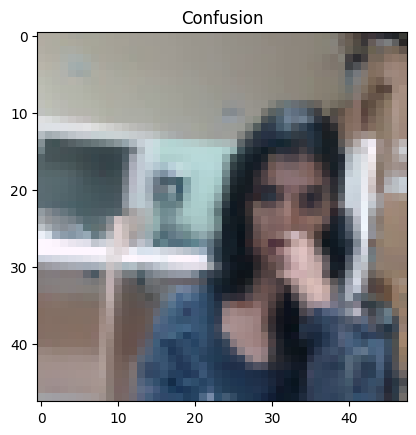

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 46, 46, 32)        896       
                                                                 
 conv2d_13 (Conv2D)          (None, 44, 44, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 22, 22, 64)        0         
 g2D)                                                            
                                                                 
 dropout_12 (Dropout)        (None, 22, 22, 64)        0         
                                                                 
 conv2d_14 (Conv2D)          (None, 20, 20, 128)       73856     
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 10, 10, 128)       0         
 ng2D)                                                

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


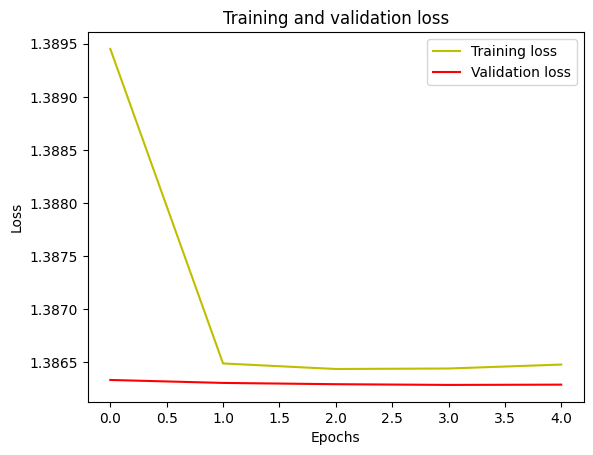

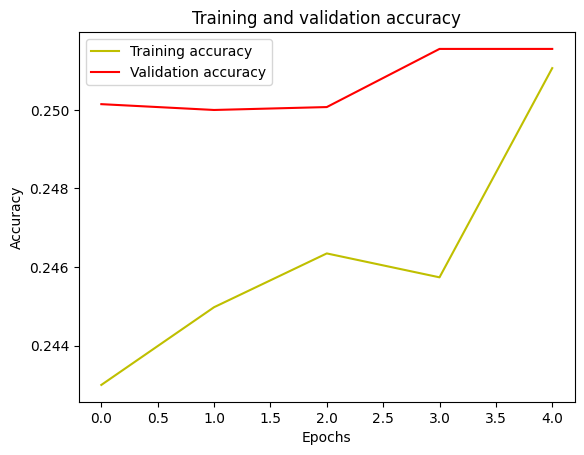

Final Training Accuracy: 0.25
Final Validation Accuracy: 0.25
1/1 [==============================] - 0s 240ms/step
Accuracy = 0.4375


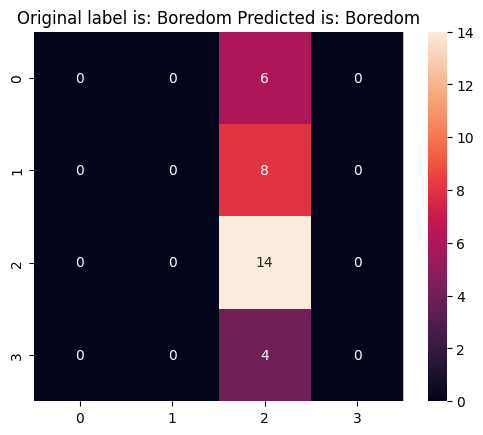

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from google.colab import drive
import os
from matplotlib import pyplot as plt
import numpy as np
import random

IMG_HEIGHT = 48
IMG_WIDTH = 48
batch_size = 32
epochs = 5
class_labels = ['Engagement', 'Frustration', 'Boredom', 'Confusion']


# Define directory paths
train_data_dir = '/content/drive/MyDrive/unzipped_folder/Classification/Frame20/Train'
validation_data_dir = '/content/drive/MyDrive/unzipped_folder/Classification/Frame20/Vaildation '  # Ensure the space and spelling

# Verify directory paths
if not os.path.exists(train_data_dir):
    print(f"Training directory {train_data_dir} does not exist.")
else:
    print("Training directory exists.")

if not os.path.exists(validation_data_dir):
    print(f"Validation directory {validation_data_dir} does not exist.")
else:
    print("Validation directory exists. Contents:")
    print(os.listdir(validation_data_dir))

# ImageDataGenerator for training and validation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1./255)

# Load data
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    color_mode='rgb',  # Using RGB mode
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    color_mode='rgb',  # Using RGB mode
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

# Verify data by plotting a sample image
img, label = next(train_generator)
i = random.randint(0, img.shape[0] - 1)
image = img[i]
labl = class_labels[label[i].argmax()]
plt.imshow(image)
plt.title(labl)
plt.show()

# Create the model
model = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.1),
    Conv2D(128, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.1),
    Conv2D(256, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.1),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.2),
    Dense(4, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Get the number of images
num_train_imgs = sum([len(files) for _, _, files in os.walk(train_data_dir)])
num_val_imgs = sum([len(files) for _, _, files in os.walk(validation_data_dir)])

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=num_train_imgs // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=num_val_imgs // batch_size
)

# Save the model
model.save('emotion_detection_model.h5')

# Plot training and validation accuracy and loss
plt.plot(history.history['loss'], 'y', label='Training loss')
plt.plot(history.history['val_loss'], 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], 'y', label='Training accuracy')
plt.plot(history.history['val_accuracy'], 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

print(f"Final Training Accuracy: {history.history['accuracy'][-1]:.2f}")
print(f"Final Validation Accuracy: {history.history['val_accuracy'][-1]:.2f}")

# Load and evaluate the model
from keras.models import load_model
my_model = load_model('emotion_detection_model.h5', compile=False)

# Generate a batch of images
test_img, test_lbl = next(validation_generator)
predictions = my_model.predict(test_img)
predictions = np.argmax(predictions, axis=1)
test_labels = np.argmax(test_lbl, axis=1)

from sklearn import metrics
print("Accuracy =", metrics.accuracy_score(test_labels, predictions))

# Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(test_labels, predictions)
sns.heatmap(cm, annot=True)

# Check results on a few select images
n = random.randint(0, test_img.shape[0] - 1)
image = test_img[n]
orig_labl = class_labels[test_labels[n]]
pred_labl = class_labels[predictions[n]]
plt.imshow(image)
plt.title("Original label is: " + orig_labl + " Predicted is: " + pred_labl)
plt.show()

In [ ]:
pip install opencv-python

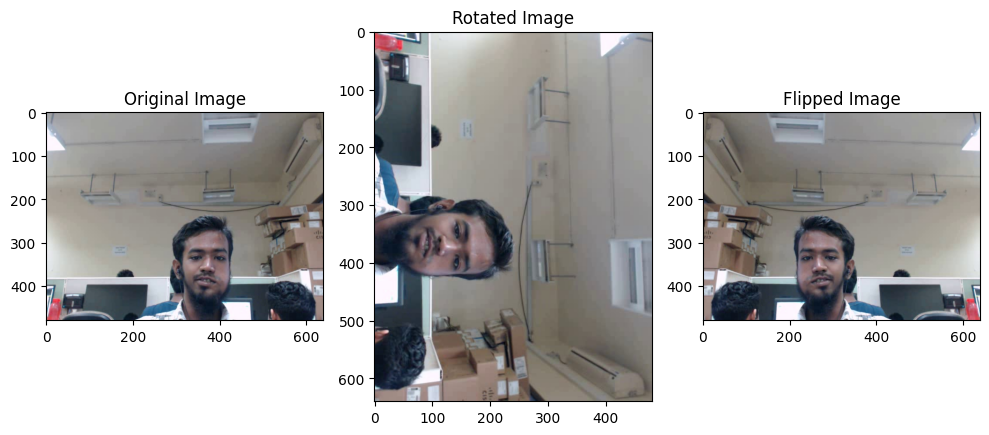

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load an image from the dataset
img_path = os.path.join(train_data_dir, 'Engagement', '/content/drive/MyDrive/unzipped_folder/Classification/Frame20/Train/Engagement/frame0000.jpg')  # Replace with an actual image path
image = cv2.imread(img_path)

# Convert BGR (OpenCV default) to RGB for displaying with matplotlib
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Apply transformations
rotated = cv2.rotate(image_rgb, cv2.ROTATE_90_CLOCKWISE)  # Rotate 90 degrees clockwise
flipped = cv2.flip(image_rgb, 1)  # Flip horizontally

# Display the original and modified images
plt.figure(figsize=(10, 5))

plt.subplot(1, 3, 1)
plt.imshow(image_rgb)
plt.title('Original Image')

plt.subplot(1, 3, 2)
plt.imshow(rotated)
plt.title('Rotated Image')

plt.subplot(1, 3, 3)
plt.imshow(flipped)
plt.title('Flipped Image')

plt.tight_layout()
plt.show()

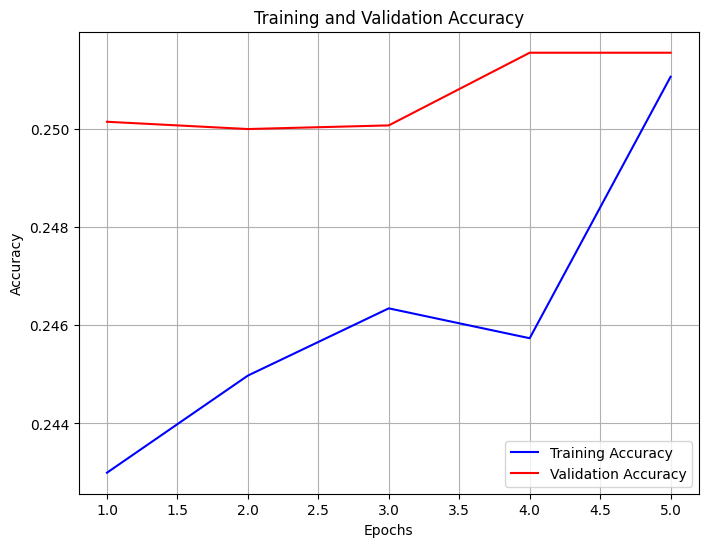

In [ ]:
import matplotlib.pyplot as plt

# Extract the accuracy and validation accuracy from the training history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Create a range of epochs to match the accuracy data
epochs_range = range(1, len(acc) + 1)

# Plot the training and validation accuracy
plt.figure(figsize=(8, 6))
plt.plot(epochs_range, acc, 'b', label='Training Accuracy')
plt.plot(epochs_range, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid()
plt.show()